# Preproc

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv('../../raw_data/2011_2021_caluire_phys_v0.csv')
df = df[['DatePrel', '1340']]
df['DatePrel'] = pd.to_datetime(df['DatePrel'])
df['month'] = df['DatePrel'].dt.month
df['year'] = df['DatePrel'].dt.year
df.groupby(['year', 'month'], as_index = False).mean()
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = 1), format = '%Y%m')
df = df.drop(columns = ['DatePrel', 'month', 'year'])
df = df.set_index('date')
df = df.rename(columns = {'1340' : 'nitrates'})
df = df.groupby(['date']).mean()
#df.head(12)

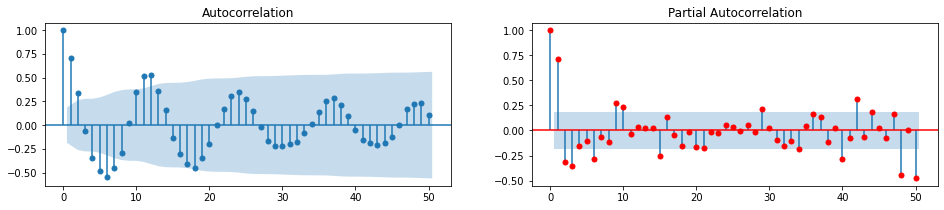

In [4]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.nitrates, lags=50, ax=axes[0]);
plot_pacf(df.nitrates, lags=50, ax=axes[1], color='r');

In [7]:
result_mul = seasonal_decompose(df['nitrates'], model = 'multiplicative', period = 12)

In [5]:
def differentials(df):
    zero_diff = df.nitrates
    first_order_diff = df.nitrates.diff(1)
    second_order_diff = df.nitrates.diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df.nitrates.values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

In [8]:
train = deseasonalized(df)[1][:89]
test = deseasonalized(df)[1][89:]

# Model

In [9]:
p, d, q = 3, 1, 2

In [10]:
arima = ARIMA(train, order=(p,d,q)).fit()


/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cristian/.pyenv/versions/3.8.12/envs/water_pollution/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.16178D-02    |proj g|=  5.93341D+00

At iterate    5    f= -7.62068D-02    |proj g|=  1.27584D+00

At iterate   10    f= -7.95624D-02    |proj g|=  2.21757D-01

At iterate   15    f= -7.97372D-02    |proj g|=  2.70220D-01

At iterate   20    f= -8.10403D-02    |proj g|=  6.07132D-02

At iterate   25    f= -8.47898D-02    |proj g|=  1.38240D-01

At iterate   30    f= -8.86955D-02    |proj g|=  2.33325D-02


 This problem is unconstrained.



At iterate   35    f= -8.87997D-02    |proj g|=  1.93584D-03

At iterate   40    f= -8.87997D-02    |proj g|=  8.20316D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     57      1     0     0   8.203D-06  -8.880D-02
  F =  -8.8799730304153973E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.linearized   No. Observations:                   88
Model:                 ARIMA(3, 1, 2)   Log Likelihood                   7.814
Method:                       css-mle   S.D. of innovations              0.215
Date:                Tue, 23 Nov 2021   AIC                             -1.629
Time:                        16:31:07   BIC                             15.713
Sample:                             1   HQIC                             5.358
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0039      0.001     -2.921      0.003      -0.007      -0.001
ar.L1.D.linearized     1.6146      0.420      3.848      0.000       0.792       2.437
ar.L2.D.linearized    -0.8667      0.490     -1.769      0.077      -1.827       0.093
ar.L3.D.linearized     0.0719      0.253      0.284      0.777      -0.425       0.568
ma.L1.D.linearized    -1.7558      0.409     -4.290      0.000      -2.558      -0.954
ma.L2.D.linearized     0.7558      0.409      1.850      0.064      -0.045       1.557
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0597           -0.5262j            1.1832           -0.0734
AR.2            1.0597           +0.5262j            1.1832            0.0734
AR.3            9.9360           -0.0000j            9.9360           -0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.3232           +0.0000j            1.3232            0.0000
-----------------------------------------------------------------------------
"""

In [12]:
forecast_arima_1, std_err_arima_1, confidence_int_arima_1 = arima.forecast(len(test), alpha=0.05)

In [13]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

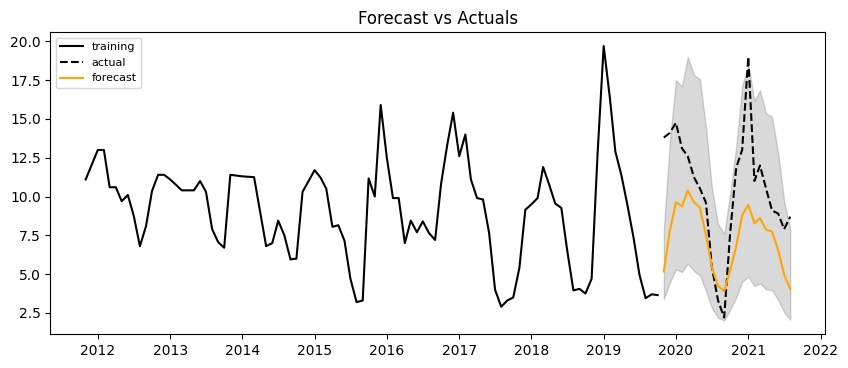

In [15]:
forecast_recons = np.exp(forecast_arima_1)*result_mul.seasonal[89:]
train_recons = np.exp(train)*result_mul.seasonal[:89]
test_recons = np.exp(test)*result_mul.seasonal[89:]
lower_recons = np.exp(confidence_int_arima_1)[:,0]*result_mul.seasonal[89:]
upper_recons = np.exp(confidence_int_arima_1)[:,1]*result_mul.seasonal[89:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)